In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 載入資料

In [2]:
# 2020 年全年 iCook 上發布的食譜與使用者收藏互動行為資料
recipes_df = pd.read_json('./data/recipes.jsonl.gz', lines=True, compression='gzip')
ingredients_df = pd.read_json('./data/ingredients.jsonl.gz', lines=True, compression='gzip')
favorites_df = pd.read_json('./data/favorites.json.gz', compression='gzip')

In [3]:
# 2021 年 1~3 月 iCook 上有收藏上述食譜的使用者 IDs
test_favorites_df = pd.read_json('./data/test_favorites.json.gz', compression='gzip')
# 2021 年 1~3 月 iCook 上有收藏上述食譜的使用者 IDs 與實際收藏的食譜 IDs（評估推薦系統使用）
test_user_ids = pd.read_csv('./data/test_user_ids.txt.gz', compression='gzip', names=['user_id'])

## 資料整理

### 是否有需要刪除的資料？（如：資料不全的、重複等）

#### 重複資料（全部欄位值相同）
參考[Finding and removing duplicate rows in Pandas DataFrame](https://towardsdatascience.com/finding-and-removing-duplicate-rows-in-pandas-dataframe-c6117668631f)。

In [4]:
recipes_df.duplicated().sum()

0

In [5]:
ingredients_df.duplicated().sum()

0

In [6]:
favorites_df.duplicated().sum()

0

#### 資料不全

##### recipes

In [7]:
num_recipes = len(recipes_df)

for i in recipes_df.columns[recipes_df.isna().any()].tolist():
    print('{0}為NaN數量: {1} ({2}%)'.format(i, recipes_df[i].isnull().sum(), round(recipes_df[i].isnull().sum() / num_recipes *100, 2)))

description為NaN數量: 5147 (18.81%)
servings為NaN數量: 1502 (5.49%)
time為NaN數量: 6226 (22.76%)


##### ingredients

In [8]:
num_ingredients = len(ingredients_df)

for i in ingredients_df.columns[ingredients_df.isna().any()].tolist():
    print('{0}為NaN數量: {1} ({2}%)'.format(i, ingredients_df[i].isnull().sum(), round(ingredients_df[i].isnull().sum() / num_ingredients *100, 2)))

group_name為NaN數量: 144731 (68.63%)


接近一半的食材資料都沒有該欄位值，故選擇捨去該欄位。

In [9]:
ingredients_df = ingredients_df.drop(['group_name'], axis=1)

##### favorites

In [10]:
num_favorites = len(favorites_df)

for i in favorites_df.columns[favorites_df.isna().any()].tolist():
    print('{0}為NaN數量: {1} ({2}%)'.format(i, favorites_df[i].isnull().sum(), round(favorites_df[i].isnull().sum() / num_favorites *100, 2)))

user_id為NaN數量: 1 (0.0%)


認為沒有user_id資料的favorites_df，不具意義，故選擇刪除該筆資料。

In [11]:
favorites_df.dropna(subset=["user_id"], inplace=True)

---

保留原始資料，複製一份出來處理。

In [12]:
recipes_tmp = recipes_df.copy()
ingredients_tmp = ingredients_df.copy()
favorites_tmp = favorites_df.copy()

---

## 資料探索

### user_id統一使用int

In [13]:
favorites_tmp.user_id = favorites_tmp.user_id.astype(int)

### 去除明顯不具有意義的欄位

認為每份食材的份量，影響用戶是否喜歡或收藏該食譜的機率偏低，故選擇捨去該欄位。

In [14]:
ingredients_tmp = ingredients_tmp.drop(['quantity'], axis=1)

### 一些好奇

#### 每份食譜通常用多少食材？其分佈？
好奇食材數會不會影響用戶？故先將食材數也加入食譜資料表中。

In [15]:
# 移除非必須、可省
ingredients_tmp = ingredients_tmp.drop(ingredients_tmp[ingredients_tmp['name'].str.contains('（非必須）')].index).reset_index(drop=True)
ingredients_tmp = ingredients_tmp.drop(ingredients_tmp[ingredients_tmp['name'].str.contains('（可省）')].index).reset_index(drop=True)

In [16]:
recipe_ingredients_count = ingredients_tmp.groupby('recipe_id') \
       .agg({'name':'size'}) \
       .rename(columns={'name':'ingredients_count'}) \
       .reset_index().sort_values('ingredients_count', ascending=False)

In [17]:
recipe_ingredients_count.ingredients_count.describe()

count    27353.000000
mean         7.708222
std          3.946373
min          1.000000
25%          5.000000
50%          7.000000
75%         10.000000
max         41.000000
Name: ingredients_count, dtype: float64

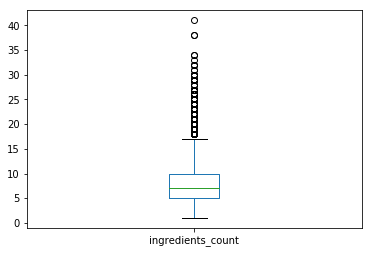

In [18]:
recipe_ingredients_count['ingredients_count'].plot.box()

將食材數加入食譜資料表中。<br>
因為考量後面會用食材做tfidf，故選擇將無食材的食譜移除。

In [19]:
print('原本食譜數: {0}'.format(len(recipes_tmp)))
recipes_tmp = pd.merge(recipe_ingredients_count, recipes_tmp, left_on="recipe_id", right_on="id", how='right')
recipes_tmp = recipes_tmp.drop(['recipe_id'], axis=1)
print('有 {0} 筆食譜沒有食材資料'.format(len(recipes_tmp[recipes_tmp.ingredients_count.isna()])))
print('移除沒有食材資料的食譜...')
recipes_tmp = recipes_tmp.drop(recipes_tmp[recipes_tmp.ingredients_count.isna()].index).reset_index(drop=True)
print('移除後食譜數: {0}'.format(len(recipes_tmp)))

原本食譜數: 27358
有 5 筆食譜沒有食材資料
移除沒有食材資料的食譜...
移除後食譜數: 27353


In [20]:
# clear not-used DataFrame
del recipe_ingredients_count

#### favorite_count、favorite_tmp中食譜被紀錄收藏數是否一致？

In [21]:
recipe_fav2020_count = favorites_tmp.groupby('recipe_id') \
       .agg({'user_id':'size'}) \
       .rename(columns={'user_id':'fav2020_count'}) \
       .reset_index().sort_values('fav2020_count', ascending=False)

In [22]:
recipes_fav_tmp = pd.merge(recipe_fav2020_count, recipes_tmp, left_on="recipe_id", right_on="id", how='right')
recipes_fav_tmp = recipes_fav_tmp.drop(['recipe_id'], axis=1)

In [23]:
print('兩者一致的有 {0} ({1}%) 筆'.format(
    recipes_fav_tmp[recipes_fav_tmp['fav2020_count'] == recipes_fav_tmp['favorites_count']].id.count(),
    round(recipes_fav_tmp[recipes_fav_tmp['fav2020_count'] == recipes_fav_tmp['favorites_count']].id.count() / len(recipes_fav_tmp) * 100, 2)
))

兩者一致的有 3443 (12.59%) 筆


In [24]:
print('兩者不一致的有 {0} ({1}%) 筆'.format(
    recipes_fav_tmp[recipes_fav_tmp['fav2020_count'] != recipes_fav_tmp['favorites_count']].id.count(),
    round(recipes_fav_tmp[recipes_fav_tmp['fav2020_count'] != recipes_fav_tmp['favorites_count']].id.count() / len(recipes_fav_tmp) * 100, 2)
))

兩者不一致的有 23910 (87.41%) 筆


In [25]:
recipes_fav_tmp[recipes_fav_tmp['fav2020_count'] > recipes_fav_tmp['favorites_count']].id.count()

0

發現兩者大多不一致，不一致的情況多為favorites_count大於fav2020_count。推測favorites_count是從發布那年(2020)一直到下載資料集時的，或許能用favorites_count-fav2020_count作為近期熱銷，favorites_count作為長期熱銷，故先加入食譜資料集中。

In [26]:
recipes_tmp = pd.merge(recipe_fav2020_count, recipes_tmp, left_on="recipe_id", right_on="id", how='right')
recipes_tmp['fav2020_count'].fillna(0, inplace=True)
recipes_tmp = recipes_tmp.drop(['recipe_id'], axis=1)

In [27]:
recipes_tmp['recent_favorites_count'] = (recipes_tmp.favorites_count - recipes_tmp.fav2020_count).fillna(0)

In [28]:
# clear not-used DataFrame
del recipes_fav_tmp

#### 食譜資料集與收藏資料集關係
想根據查看以下兩個面向，決定若用cf該是user-based好？還是item-based？
- 每份食譜通常被多少人收藏？其分佈？
- 每個人通常收藏多少食譜？其分佈？

##### 用戶收藏過多少食譜？

In [29]:
favorites_user = favorites_tmp.groupby('user_id') \
       .agg({'recipe_id':'size'}) \
       .rename(columns={'recipe_id':'favorites_count'}) \
       .reset_index().sort_values('favorites_count', ascending=False)
favorites_user.head()

,user_id,favorites_count
23770,318496,8155
82195,1169007,7166
16846,221194,6142
54313,754960,5613
81925,1164973,5459


In [30]:
print(favorites_user['favorites_count'])
print('這些人平均對多少食譜收藏 {0}'.format(favorites_user['favorites_count'].mean()))

23770     8155
82195     7166
16846     6142
54313     5613
81925     5459
          ... 
96223        1
96218        1
96215        1
96209        1
200849       1
Name: favorites_count, Length: 200850, dtype: int64
這些人平均對多少食譜收藏 5.176694050286283


但認為只有收藏過一個食譜的用戶沒有用，因為由該食譜找到與用戶相似後，就無能推薦的食譜，故移除該用戶。

In [31]:
favorites_user = favorites_user[favorites_user['favorites_count'] > 1]

In [32]:
print(favorites_user['favorites_count'])
print('這些人平均收藏多少食譜 {0}'.format(favorites_user['favorites_count'].mean()))

23770     8155
82195     7166
16846     6142
54313     5613
81925     5459
          ... 
16654        2
173174       2
13154        2
170225       2
16288        2
Name: favorites_count, Length: 116464, dtype: int64
這些人平均收藏多少食譜 8.202989765077621


In [33]:
favorites_user['favorites_count'].describe()

count    116464.000000
mean          8.202990
std          52.081415
min           2.000000
25%           2.000000
50%           4.000000
75%           7.000000
max        8155.000000
Name: favorites_count, dtype: float64

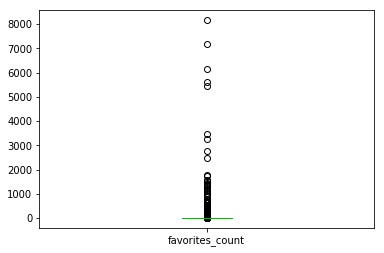

In [34]:
favorites_user['favorites_count'].plot.box()

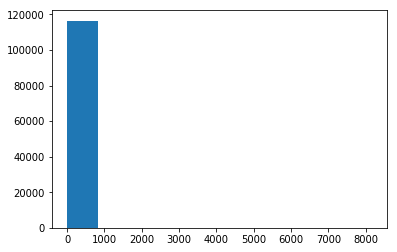

將評分商品數超過8個的放大來看...


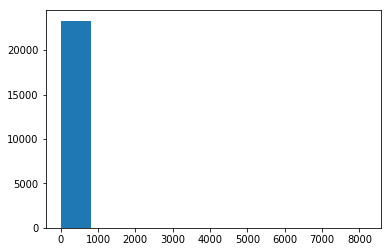

將評分商品數超過60個的放大來看...


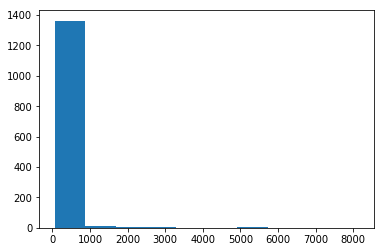

將評分商品數超過112個的放大來看...


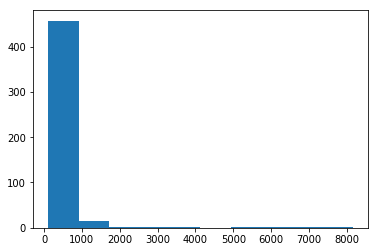

將評分商品數超過1000個的放大來看...


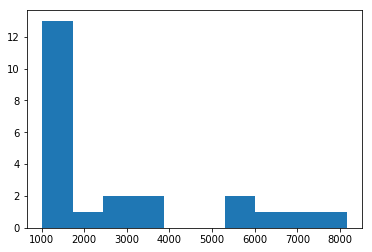

In [35]:
plt.hist(favorites_user['favorites_count'])
plt.show()
print('將評分商品數超過8個的放大來看...')
plt.hist(favorites_user[favorites_user['favorites_count']> 8]['favorites_count'])
plt.show()
print('將評分商品數超過60個的放大來看...')
plt.hist(favorites_user[favorites_user['favorites_count'] > 60]['favorites_count'])
plt.show()
print('將評分商品數超過112個的放大來看...')
plt.hist(favorites_user[favorites_user['favorites_count'] > 112]['favorites_count'])
plt.show()
print('將評分商品數超過1000個的放大來看...')
plt.hist(favorites_user[favorites_user['favorites_count'] > 1000]['favorites_count'])
plt.show()

##### 在食譜有多少被收藏？

In [36]:
favorites_recipe = favorites_tmp.groupby('recipe_id') \
       .agg({'user_id':'size'}) \
       .rename(columns={'user_id':'users_count'}) \
       .reset_index().sort_values('users_count', ascending=False)
favorites_recipe.head()

,recipe_id,users_count
22055,354535,2300
3071,324324,1947
17204,346764,1858
7150,330968,1779
2832,323921,1777


In [37]:
print(favorites_recipe['users_count'])
print('這些食譜平均被多少用戶收藏: {0}'.format(favorites_recipe['users_count'].mean()))

22055    2300
3071     1947
17204    1858
7150     1779
2832     1777
         ... 
9307        1
14693       1
20706       1
5551        1
10726       1
Name: users_count, Length: 26616, dtype: int64
這些食譜平均被多少用戶收藏: 39.064434926360086


但認為只有被一個用戶收藏的食譜，表示只有一個用戶收藏，無法推薦給其他用戶，因為由其他用戶找曾收藏食譜找到食譜後，不會跟這個食譜有任何相似，故移除該食譜。

In [38]:
favorites_recipe = favorites_recipe[favorites_recipe['users_count'] > 1]

In [39]:
print(favorites_recipe['users_count'])
print('這些食譜平均被多少用戶收藏: {0}'.format(favorites_recipe['users_count'].mean()))

22055    2300
3071     1947
17204    1858
7150     1779
2832     1777
         ... 
16086       2
24849       2
15931       2
10990       2
10754       2
Name: users_count, Length: 25939, dtype: int64
這些食譜平均被多少用戶收藏: 40.057905085007135


In [40]:
favorites_recipe['users_count'].describe()

count    25939.000000
mean        40.057905
std         81.410381
min          2.000000
25%          8.000000
50%         17.000000
75%         39.000000
max       2300.000000
Name: users_count, dtype: float64

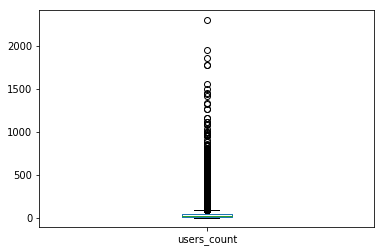

In [41]:
favorites_recipe['users_count'].plot.box()

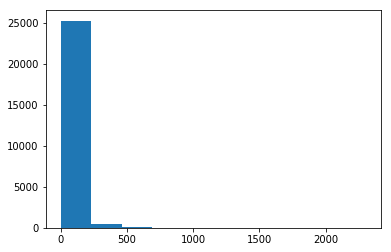

將評分商品數超過8個的放大來看...


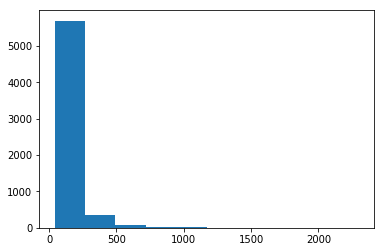

將評分商品數超過60個的放大來看...


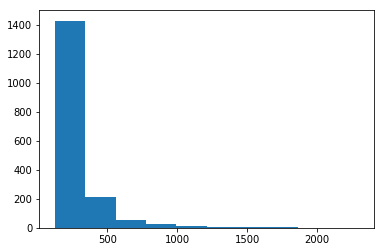

將評分商品數超過112個的放大來看...


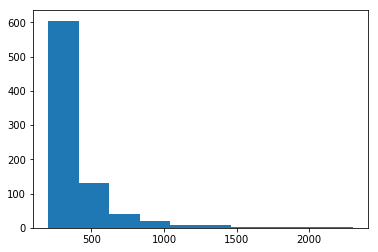

將評分商品數超過1000個的放大來看...


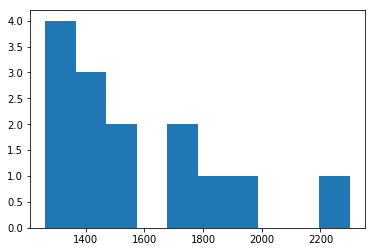

In [42]:
plt.hist(favorites_recipe['users_count'])
plt.show()
print('將評分商品數超過8個的放大來看...')
plt.hist(favorites_recipe[favorites_recipe['users_count']> 40]['users_count'])
plt.show()
print('將評分商品數超過60個的放大來看...')
plt.hist(favorites_recipe[favorites_recipe['users_count'] > 121]['users_count'])
plt.show()
print('將評分商品數超過112個的放大來看...')
plt.hist(favorites_recipe[favorites_recipe['users_count'] > 202]['users_count'])
plt.show()
print('將評分商品數超過1000個的放大來看...')
plt.hist(favorites_recipe[favorites_recipe['users_count'] > 1200]['users_count'])
plt.show()

初步推斷item-based可能表現會比較好，由於分佈的較密集。
但乃會兩個資料皆保留，待之後測試看看。

In [43]:
# user-based 剔除收藏資料表中收藏數小於等於1的用戶
favorites_tmp_user = favorites_tmp[favorites_tmp['user_id'].isin(favorites_user['user_id'].unique())]
print('剩下多少用戶: {0} ({1})'.format(favorites_tmp_user.user_id.nunique(), 
                                 round(favorites_tmp_user.user_id.nunique()/ favorites_tmp.user_id.nunique() * 100, 2)))
# item-based 剔除收藏資料表中收藏數小於等於1的食譜
recipes_tmp_item = recipes_tmp[recipes_tmp['id'].isin(favorites_recipe['recipe_id'].unique())]
print('剩下多少食譜: {0} ({1})'.format(len(recipes_tmp_item), 
                                 round(len(recipes_tmp_item)/ recipes_tmp.id.nunique() * 100, 2)))

剩下多少用戶: 116464 (57.99)
剩下多少食譜: 25935 (94.82)


In [44]:
# clear not-used DataFrame
del favorites_user
del favorites_recipe

### recipes欄位取捨
初步評估，將分成以下三個方向處理。
- description、name、食材：可做tdidf
- favorites_count、dishes_count、photo_steps_count、text_steps_count、time、ingredients_count：資料探索，思考是否與用戶喜愛有關聯，接著思考怎麼用？normalize或分成高中低？
- published_at：改成月份(因為可能會有季節性食譜？)

In [45]:
recipes_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27353 entries, 0 to 27352
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   fav2020_count           27353 non-null  float64       
 1   ingredients_count       27353 non-null  float64       
 2   id                      27353 non-null  int64         
 3   name                    27353 non-null  object        
 4   description             22208 non-null  object        
 5   user_id                 27353 non-null  int64         
 6   servings                25854 non-null  float64       
 7   time                    21130 non-null  float64       
 8   favorites_count         27353 non-null  int64         
 9   dishes_count            27353 non-null  int64         
 10  text_steps_count        27353 non-null  int64         
 11  photo_steps_count       27353 non-null  int64         
 12  published_at            27353 non-null  dateti

In [46]:
recipes_tmp['MONTH'] = recipes_tmp['published_at'].dt.month

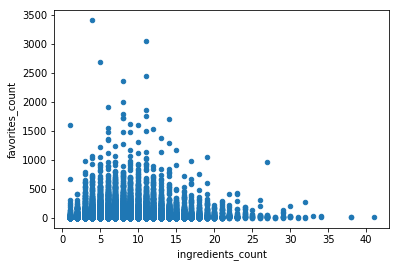

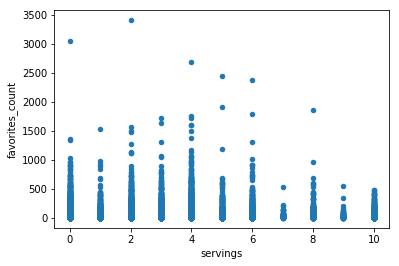

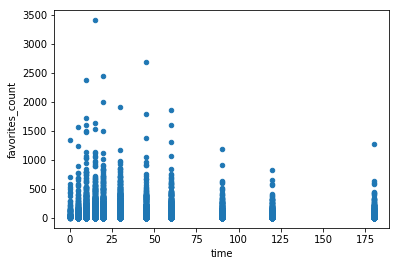

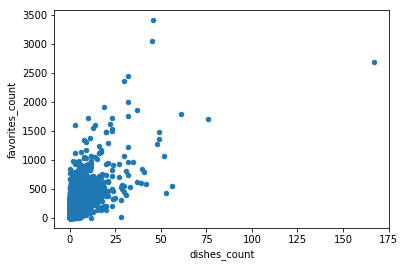

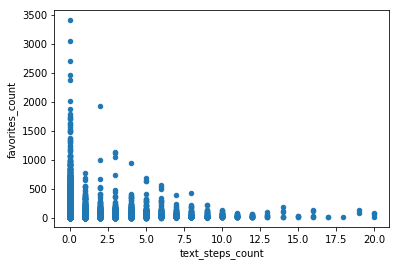

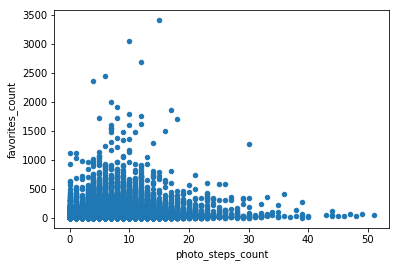

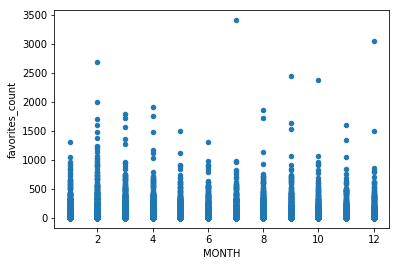

In [47]:
recipes_cols = ['ingredients_count', 'servings', 'time', 'dishes_count', 'text_steps_count', 'photo_steps_count', 'MONTH']

for col_name in recipes_cols:
    recipes_tmp.plot.scatter(x=col_name, y="favorites_count")

明顯的看出來被收藏的數量與dishes_count、published_at(以MONTH代表)無關，故選擇先移除。

In [48]:
recipes_tmp = recipes_tmp.drop(['dishes_count', 'published_at'], axis=1)

而photo_steps_count、time、ingredients_count在某區間內大受收藏的機率較高，text_steps_count則是越少越可能大受收藏，而servings則不太一定，推測可能會跟用戶本身有關。

將time、servings的NaN補0。

In [49]:
recipes_tmp.time.fillna(0.0, inplace=True)
recipes_tmp.servings.fillna(0.0, inplace=True)

#### 加入季節性
(`None`: 代表商品無季節性)

In [50]:
def MonthToSeason(x):   
    global season
    if x == 3 or x == 4 or x == 5:
         season = "Spring"
    elif x == 6 or x == 7 or x == 8:
         season = "Summer"
    elif x == 9 or x == 10 or x == 11:
         season = "Autumn"
    elif x == 12 or x == 1 or x == 2:
         season = "Winter"
    else:
         season = np.nan 
    return season

tmp_data = favorites_tmp.copy()
tmp_data['SEASON'] = favorites_tmp['created_at'].dt.month.apply(lambda x : MonthToSeason(x))
tmp_data.head()

,recipe_id,user_id,created_at,SEASON
0,319968,1474700,2020-01-01 04:30:24,Winter
1,319968,2897690,2020-01-01 04:41:12,Winter
2,319968,938575,2020-01-01 05:00:42,Winter
3,319968,839280,2020-01-01 05:13:30,Winter
4,319968,1292248,2020-01-01 05:19:50,Winter


In [51]:
tmp_data = tmp_data.groupby(['SEASON', 'recipe_id']).size().reset_index(name='count')

tmp_data = tmp_data.pivot(index='recipe_id', columns='SEASON',values='count').reset_index()
tmp_data.fillna(0.0, inplace=True)
tmp_data.set_index("recipe_id" , inplace=True)

In [52]:
tmp_data['sum'] = tmp_data[['Autumn', 'Spring', 'Summer', 'Winter']].sum(axis=1).astype(int)

sum_threshold = 60
tmp_data = tmp_data[tmp_data['sum'] > sum_threshold]  # 希望至少有一定的收藏紀錄才做判別

tmp_data['mean'] = tmp_data[['Autumn', 'Spring', 'Summer', 'Winter']].mean(axis=1).round(2).astype(float)
tmp_data['std'] = tmp_data[['Autumn', 'Spring', 'Summer', 'Winter']].std(axis=1).round(3).astype(float)
tmp_data['fstd'] = tmp_data['std'] / tmp_data['mean']  # fixed std

In [53]:
# 使用fstd篩選
season_tmp_data = tmp_data[tmp_data['fstd'] > 1]
print('以最低至少{0}的銷售紀錄為門檻時，得到的季節性商品占全部商品的約{1}%。\n'.format(sum_threshold, round(len(season_tmp_data) / len(tmp_data) * 100)))
print(season_tmp_data)

以最低至少60的銷售紀錄為門檻時，得到的季節性商品占全部商品的約76%。

SEASON     Autumn  Spring  Summer  Winter  sum   mean     std      fstd
recipe_id                                                              
118471       90.0     0.0     0.0    10.0  100  25.00  43.589  1.743560
161963       33.0     0.0   122.0     7.0  162  40.50  56.158  1.386617
220200      118.0     0.0     0.0    10.0  128  32.00  57.527  1.797719
250670        2.0    40.0     6.0   106.0  154  38.50  48.121  1.249896
271725        6.0     0.0    87.0     1.0   94  23.50  42.415  1.804894
...           ...     ...     ...     ...  ...    ...     ...       ...
361636        0.0     0.0     0.0   183.0  183  45.75  91.500  2.000000
361745        0.0     0.0     0.0    79.0   79  19.75  39.500  2.000000
361811        0.0     0.0     0.0    63.0   63  15.75  31.500  2.000000
361839        0.0     0.0     0.0   167.0  167  41.75  83.500  2.000000
361953        0.0     0.0     0.0    82.0   82  20.50  41.000  2.000000

[3022 rows x 8 columns]


In [54]:
season_data = season_tmp_data.drop(['sum', 'mean', 'std', 'fstd'], axis=1)
season_data = season_data.idxmax(axis=1).reset_index(name='SEASON')
season_data

,recipe_id,SEASON
0,118471,Autumn
1,161963,Summer
2,220200,Autumn
3,250670,Winter
4,271725,Summer
...,...,...
3017,361636,Winter
3018,361745,Winter
3019,361811,Winter
3020,361839,Winter


認為可能會出現誤判，因為此收藏紀錄只有2020年的，若食譜在下半年才出現，可能容易被歸類為秋季或冬季食譜，故將判為秋、冬季食譜，且發布在2020年7月以後的排除，改判為None。

In [55]:
recipe_season_data = recipes_tmp.merge(season_data, left_on='id', right_on='recipe_id')

In [56]:
len(recipe_season_data)

3022

In [57]:
recipe_season_data = recipe_season_data.drop(recipe_season_data[(recipe_season_data['SEASON'].isin(['Winter', 'Autumn'])) & 
                             (recipe_season_data['MONTH'] > 6)].index).reset_index(drop=True)

In [58]:
len(recipe_season_data)

2273

In [59]:
recipe_season_data = recipe_season_data[['id', 'SEASON']]

In [60]:
recipe_season_data

,id,SEASON
0,319968,Winter
1,319797,Winter
2,319979,Winter
3,319981,Winter
4,319973,Winter
...,...,...
2268,349434,Summer
2269,349813,Summer
2270,349886,Summer
2271,350033,Summer


In [61]:
recipes_tmp = pd.merge(recipe_season_data, recipes_tmp, on="id", how='right')
recipes_tmp['SEASON'].fillna('None', inplace=True)

In [62]:
# clear not-used DataFrame
del tmp_data
del season_data
del recipe_season_data

#### tdidf

將食材資料表與食譜資料表合併。

In [63]:
gb = ingredients_tmp.groupby(['recipe_id'])
result = gb['name'].unique()
result = pd.DataFrame(result)
result = result.reset_index()
result.name = result.name.apply(lambda x: ' '.join(x))
result = result.rename(columns={'name':'ingredients'})

In [64]:
recipes_tmp = pd.merge(result, recipes_tmp, left_on="recipe_id", right_on="id", how='right')
recipes_tmp = recipes_tmp.drop(['recipe_id'], axis=1)

文字前處理

In [65]:
recipes_tmp['description'].fillna('', inplace=True)

In [66]:
# 合併三個文字欄位
recipes_tmp['ALL_TEXT'] = recipes_tmp['name'] + ' ' + recipes_tmp['description'] + ' ' + recipes_tmp['ingredients']

In [67]:
recipes_tmp['ALL_TEXT']

0                                           鮮奶燉蛋  雞蛋 鮮奶 砂糖
1        初次醃蘿蔔【鬼怪】 前陣子電視重播時才迷上「鬼怪」，雖然穿差著看，但老闆娘的「醃蘿蔔」單配酒...
2        零基礎免揉-哈拉Challah辮子麵包\n 不需要理論基礎\n也不需要桌上型攪拌機\n的五分...
3        洋蔥豬扒 簡單的兩樣食材，没有花巧的煮法，美味可口，吃得滿足。 梅頭豬扒 洋蔥 蕃茄醬 糖 ...
4                             蒜香肉絲小松菜  小松菜 肉絲 醬油 蒜頭 米酒 鹽 水
                               ...                        
27348    藥膳火鍋鍋底 最近細雨綿綿加寒風刺骨，來一道熱呼呼藥膳火鍋，輕輕鬆鬆補補身子驅除寒氣。 大雞...
27349              在家自製斧頭扒～大廚級出馬  斧頭牛扒 無鹽牛油 黑椒粉 蒜頭 鹽 油 香草碎
27350    皮蛋瘦肉粥（健康）（減肥）（零失敗） 蔬菜比例的調配\n低碳飲食，健康生活\n冷冷的冬天\n...
27351    簡易櫻花蝦蘿蔔糕 因為要煮成蘿蔔糕湯，所以沒有特別加豬肉和香菇。\n如果要直接煎來吃的可以自...
27352    咔拉炸雞大破解 市售的脆粉漿如果讓你食不安心，其實也不要慌，因為喀拉脆粉真的沒有你相像中那麽...
Name: ALL_TEXT, Length: 27353, dtype: object

斷詞
參考[資料分析概念大全｜認識文本分析](https://medium.com/datamixcontent-lab/%E6%96%87%E6%9C%AC%E5%88%86%E6%9E%90%E5%85%A5%E9%96%80-%E6%A6%82%E5%BF%B5%E7%AF%87-%E7%B5%A6%E6%88%91%E4%B8%80%E6%AE%B5%E8%A9%B1-%E6%88%91%E5%91%8A%E8%A8%B4%E4%BD%A0%E9%87%8D%E9%BB%9E%E5%9C%A8%E5%93%AA-%E5%B0%8D%E6%96%87%E6%9C%AC%E9%87%8D%E9%BB%9E%E5%AD%97%E8%A9%9E%E5%8A%A0%E6%AC%8A%E7%9A%84tf-idf%E6%96%B9%E6%B3%95-f6a2790b4991)、[如何用sklearn计算TF-IDF](https://www.cnblogs.com/CheeseZH/p/8644893.html)。

In [68]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
import jieba
jieba.set_dictionary('./dict.txt.big.txt') # 使用官方的繁體詞典

In [69]:
with open('./stopwords.txt', 'rb') as fp:
    stopword = fp.read().decode('utf-8')  # 提用詞提取
#將停用詞表轉換爲list  
stpwrdlst = stopword.splitlines()

In [70]:
def preprocessing(sentences):
    w_string = str()
    ws = jieba.cut(sentences, cut_all=False) # 精確模式
    for w in ws:
        if w not in stpwrdlst:
            w_string += w + ' '
    return w_string
recipes_tmp['ALL_TEXT'] = recipes_tmp['ALL_TEXT'].apply(lambda x: preprocessing(x))

Building prefix dict from /Users/stork/03_Project/class/AC_RecSys2/S7/dict.txt.big.txt ...
Loading model from cache /var/folders/x3/fgk9qlk519xgr2nh11ndchz80000gn/T/jieba.u388ab37af5129dca46686fb240c351ab.cache
Loading model cost 1.459 seconds.
Prefix dict has been built successfully.


In [71]:
recipes_tmp['ALL_TEXT']

0                                 鮮奶 燉 蛋     雞蛋   鮮奶   砂糖 
1        初次 醃 蘿蔔 鬼怪   前 陣子 電視 重播 時才 迷上 鬼怪 穿 差著 老闆娘 醃 蘿蔔...
2        基礎 揉 哈拉 Challah 辮子 麵 包 \n   理論 基礎 \n 桌上型 攪拌機 \...
3        洋蔥 豬扒   簡單 兩樣 食材 没有 花巧 煮法 美味可口   梅頭 豬扒   洋蔥   ...
4          蒜 香 肉絲 小松菜     小松菜   肉絲   醬油   蒜頭   米酒   鹽   水 
                               ...                        
27348    藥膳 火鍋 鍋底   細雨綿綿 寒風刺骨 熱呼呼 藥膳 火鍋 輕輕鬆鬆 補補 身子 驅除 寒...
27349    在家 斧頭 扒 大廚 級 出馬     斧頭 牛扒   無鹽 牛油   黑椒 粉   蒜頭 ...
27350    皮蛋 瘦肉粥 健康 減肥 失敗   蔬菜 比例 調配 \n 低碳 飲食 健康 生活 \n 冷...
27351    簡易 櫻花 蝦 蘿蔔 糕   煮成 蘿蔔 糕湯 特別 豬肉 香菇 \n 煎 豬肉 香菇 香 ...
27352    咔拉 炸雞 破解   市售 脆 粉漿 食 安心 慌 喀拉 脆粉 真的 相像 中 難 原理 喀...
Name: ALL_TEXT, Length: 27353, dtype: object

In [72]:
vectoerizer = CountVectorizer(max_features=1000, max_df=0.9, token_pattern='\\b\\w+\\b', stop_words=stpwrdlst)
vectoerizer.fit(recipes_tmp['ALL_TEXT'])
bag_of_words = vectoerizer.get_feature_names()
X = vectoerizer.transform(recipes_tmp['ALL_TEXT'])

/anaconda3/envs/t/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['a', 'lex', 'n', 'β', 'δ', 'λ', 'ξ', 'ψ', 'в', 'ⅴ', 'ⅵ', '①①', '①②', '①③', '①④', '①⑤', '①⑥', '①⑦', '①⑧', '①⑨', '①ａ', '①ｂ', '①ｃ', '①ｄ', '①ｅ', '①ｆ', '①ｇ', '①ｈ', '①ｉ', '①ｏ', '②①', '②②', '②③', '②④', '②⑤', '②⑥', '②⑦', '②⑧', '②⑩', '②ａ', '②ｂ', '②ｄ', '②ｅ', '②ｆ', '②ｇ', '②ｈ', '②ｉ', '②ｊ', '③①', '③⑩', '③ａ', '③ｂ', '③ｃ', '③ｄ', '③ｅ', '③ｆ', '③ｇ', '③ｈ', '④ａ', '④ｂ', '④ｃ', '④ｄ', '④ｅ', '⑤ａ', '⑤ｂ', '⑤ｄ', '⑤ｅ', '⑤ｆ', '元', '噸', '數', '日', '末', '１２', 'ａ', 'ｂ', 'ｃ', 'ｅ', 'ｆ', 'ｌ', 'ｌｉ', 'ｒ', 'ｚｘｆｉｔｌ'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [73]:
print(bag_of_words)

['3cvknyl', 'diy', 'e5', 'gl', 'goo', 'hd9642', 'house', 'little', 'ly', 'omnipork', 'popo320pig', 'small', 'tudoubar', 'womanritaskitchen', '一', '七味', '三層', '三明治', '三杯', '上桌', '上菜', '下午茶', '下酒菜', '下飯', '不想', '不膩', '不錯', '不難', '中', '中筋', '丸', '丸子', '丼', '九層', '乳酪', '乾', '乾燥', '二砂', '五花', '五花肉', '五香粉', '享受', '享用', '仔', '仔魚', '令人', '以表', '份量', '伯爵', '低', '低筋', '低脂', '佐', '來源', '來點', '便宜', '便當', '保存', '做做', '做出', '做好', '做成', '健康', '傳統', '優格', '充滿', '光泉', '入口', '入味', '內餡', '全國', '全素', '全聯', '全蛋', '全麥', '兩種', '八角', '冬天', '冬瓜', '冬粉', '冰', '冰塊', '冰淇淋', '冰箱', '冰糖', '冷', '冷凍', '冷水', '冷藏', '凍', '分', '分鐘', '切丁', '切塊', '切末', '切段', '切片', '切碎', '切絲', '利用', '前', '剝皮', '剩下', '創意', '加熱', '加點', '動手', '動手做', '動物性', '包', '包粉', '十足', '千層', '千張', '午餐', '南洋', '南瓜', '卡士', '即可', '卷', '原味', '去皮', '參考', '取代', '口', '口味', '口感', '古早', '可不', '可口', '可可', '可可粉', '可愛', '可樂', '可用', '可略', '台式', '台灣', '吃不完', '吉利', '吋', '吐司', '含', '含有', '含量', '吻', '呦', '味增', '味精', '味道', '味霖', '咖哩', '咖哩粉', '咖啡', '咖喱', '品嚐', '啤酒', '喜好', '喜愛'

In [74]:
tfidf_transformer = TfidfTransformer()
tfidf_transformer.fit(X.toarray())

# for idx, word in enumerate(vectoerizer.get_feature_names()):
#   print("{}\t{}".format(word, tfidf_transformer.idf_[idx]))

tmp_word_features = tfidf_transformer.transform(X)
# print(tmp_word_features.toarray())

In [75]:
tmp_word_features.toarray().size

27353000

In [76]:
len(recipes_tmp) * 200

5470600

In [77]:
len(vectoerizer.get_feature_names())

1000

加入食譜資料表中。

In [78]:
word_features = pd.DataFrame(tmp_word_features.toarray(), columns = np.array(vectoerizer.get_feature_names()))

In [ ]:
# recipes_tmp_word = pd.concat([recipes_tmp, word_features], axis=1)

In [79]:
# clear not-used DataFrame
del gb
del result
del vectoerizer
del bag_of_words
del X
del tfidf_transformer

---

## 特徵選擇

In [82]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

# ct = ColumnTransformer([
#         ('servings', StandardScaler(), ['servings'])
#     ], remainder='passthrough')

# a['servings'] = ct.fit_transform(a)

In [83]:
recipes_features_list = ['SEASON', 'user_id', 'ALL_TEXT', 'servings', 'time', 'favorites_count', 'text_steps_count', 'photo_steps_count', 'ingredients_count']

In [84]:
def get_features(df, cols_list=['ALL_TEXT'], is_normalized=False, norm=StandardScaler()):
#     cols_list = cols_list + ['id']
    df = df.drop([col for col in recipes_tmp.columns if col not in cols_list], axis=1)
    for col in cols_list:
        if (col == 'ALL_TEXT'):
            df = pd.concat([df, word_features], axis=1)
            df = df.drop(['ALL_TEXT'], axis=1)
        elif ((col in recipes_features_list[3:]) & is_normalized):
            # normalized
            ct = ColumnTransformer([
                    ('servings', norm, [col])
                ], remainder='passthrough')
            df[col] = ct.fit_transform(df)
    return df

---

## 若找不到相似的替代算法

#### 長期熱銷(favorites_count)

In [85]:
def get_longterm_top(k=3):
    longterm_top = recipes_tmp.sort_values('favorites_count', ascending=False).head(k).id.reset_index(drop=True).to_list()
    return longterm_top

#### 近期熱銷(favorites_count-fav2020_count)

In [86]:
def get_recent_top(k=3):
    recent_top = recipes_tmp.sort_values('recent_favorites_count', ascending=False).head(k).id.reset_index(drop=True).to_list()
    return recent_top

長期熱銷 vs 近期熱銷 一致性？

---

### Content-based

In [87]:
# # 計算商品間的相似程度
# from sklearn.metrics.pairwise import cosine_similarity
# similarity_matrix = cosine_similarity(tfidf_matrix)
# mapping = pd.Series(df.index,index = df['title'])

from sklearn.metrics.pairwise import cosine_similarity

# 每個商品回傳 k 個最相近的商品
def recommend_item(similarity_matrix, mapping, item_input, k=3):
    try:
        item_index = mapping[item_input]
        similarity_score = list(enumerate(similarity_matrix[item_index]))
        similarity_score = sorted(similarity_score, key=lambda x: x[1], reverse=True)
        similarity_score = similarity_score[:k]
        item_indices = [i[0] for i in similarity_score]
        return (df['id'].iloc[item_indices].tolist())
    except:
        return []

# 利用使用者購買過的商品產生推薦
def recommend_items(similarity_matrix, mapping, items, k=3):
    res = []
    for d in items:
        res.extend(recommend_item(similarity_matrix, mapping, d, k))
    return res

### user-based cf

In [ ]:
# favorites_tmp

In [ ]:
# from lightfm.data import Dataset
# import nltk
# from nltk.corpus import stopwords
# from nltk.stem import WordNetLemmatizer

# pd.options.mode.chained_assignment = None
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')

# from lightfm import LightFM
# import numpy as np

# def recommend_items(model, data, user_id, item_list, k):
    
#     # 取得item數量
#     n_users, n_items = data.shape

#     # 預測user對所有item的評分並進行推薦
#     scores = model.predict(user_id, np.arange(n_items))
#     top_items = item_list[np.argsort(-scores)]
#     return top_items[:k].tolist()


# def recommender(training_data, users=[], k=10, rule_based = False, add_test_user = False, add_item_feature = False, metadata = ''):
#     '''
#     * training_data: dataframe 輸入的訓練資料集（2018-09-01 以前資料）
#     * users: [] 需要被推薦的使用者
#     * k: int 每個使用者需要推薦的商品數
#     * recommendations: dict
#       {
#           使用者一： [推薦商品一, 推薦商品二, ...],
#           使用者二： [...], ...
#       }
#     '''
#     # 移除使用者對商品的重複評論，只留最新
#     training_data = training_data.sort_values("DATE", ascending=False).groupby(['reviewerID', 'asin']).head(1)
#     recommendations = {}
#     '''
#     mf-based, lightFM
#     '''
#     # Rule based
#     if rule_based and isinstance(training_data, pd.DataFrame):
#         hot = training_data[(training_data['DATE'] >= '2018-08-01') & (training_data['DATE'] < '2018-09-01') & (training_data['overall'] >= 4)]
#         hot = pd.DataFrame(hot.asin.value_counts())
#         hot.reset_index(inplace=True)
#         hot.columns = ['asin', 'count']
    
#     # 取出評分矩陣所需的訓練資料並以lightfm的Dataset形式存取
#     training_data = training_data[["reviewerID","asin","overall"]]
#     dataset = Dataset()

#     if add_test_user:
#         dataset.fit(np.append(training_data.reviewerID.unique(), users, 0), training_data.asin.unique())
#     else:
#         dataset.fit(training_data.reviewerID.unique(), training_data.asin.unique())
    
#     interactions_matrix, weights_matrix = dataset.build_interactions([tuple(i) for i in training_data.values])


#     # 取得user與item的mapping資料
#     user_id_map, user_feature_map, item_id_map, item_feature_map = dataset.mapping()
#     item_list = np.array(list(item_id_map.keys())).astype(object)

#     # 訓練模型
#     if add_item_feature:
#         assert isinstance(metadata, pd.DataFrame), "Please input the item's data"
#         # 篩選資料
#         metadata = metadata[metadata.asin.isin(training_data.asin.tolist())]
#         metadata.reset_index(drop=True, inplace=True)
        
#         # set lemmatizer
#         lemmatizer = WordNetLemmatizer()
        
#         # 處理掉description 的中括號
#         metadata['description'] = metadata['description'].apply(lambda x: ' '.join(x))

#         # 處理rank
#         rankdata = metadata['rank'].str.split(' ', n=1, expand=True)
#         metadata['rank_no'], metadata['rank'] = rankdata.iloc[:,0], rankdata.iloc[:,1]

#         # 合併文字欄位
#         metadata['all_text'] = metadata['description'] + ' ' + metadata['title'] # + ' ' + metadata['rank'] + ' ' + metadata['brand']

#         # 去除特殊符號，除了數字之間的
#         import re
#         regex = r"(?<!\d)[\W](?!\d)"
#         metadata['all_text'] = metadata['all_text'].apply(lambda x: re.sub(regex, ' ', str(x)))
#         metadata['rank'] = metadata['rank'].apply(lambda x: re.sub(regex, ' ', str(x)))
#         metadata['brand'] = metadata['brand'].apply(lambda x: re.sub(regex, ' ', str(x)))

#         # 轉小寫
#         metadata['all_text'] = metadata['all_text'].str.lower()
#         metadata['rank'] = metadata['rank'].str.lower() 
#         metadata['brand'] = metadata['brand'].str.lower()         

#         # remove stopword
#         def remove_stopword(sentence):
#             tokens = nltk.word_tokenize(sentence)
#             result = [lemmatizer.lemmatize(voca) for voca in tokens if not voca in stopwords.words('english')]
#             return result

#         metadata['all_text'] = metadata['all_text'].apply(lambda x: remove_stopword(x))

#         # merge column
#         for i in range(len(metadata)):
#             try:
#                 metadata['all_text'][i] = metadata['all_text'][i].append(metadata['rank'][i]).append(metadata['brand'][i])
#             except:
#                 metadata['all_text'][i] = []

#         # 建立隱性標籤
#         item_features = dataset.build_item_features([tuple(x) for x in metadata[['asin','all_text']].values])

#         # 訓練混合模型（Hybrid Model）加入 user / item feature
#         model = LightFM(loss='warp', item_alpha=1e-6, no_components=100)
#         model = model.fit(interactions_matrix, sample_weight = weights_matrix, item_features=item_features, epochs=20, num_threads=8)

#     else:
#         model = LightFM(loss='warp', item_alpha=1e-6, no_components=100)
#         model = model.fit(interactions_matrix, sample_weight = weights_matrix, epochs=20, num_threads = 8)

#     # 推薦
#     for user in users:
#         try:
#             recommendations[user] = recommend_items(model, interactions_matrix, user_id_map[user], item_list, k)
#         except:
#             if rule_based:
#                 recommendations[user] = hot.asin[:k].tolist()
#             else:
#                 recommendations[user] = []

#     return recommendations

## 計算推薦

cmethod(1: content-based, 2: user-based, 3: item-based)<br>
rmethod(1: long-term, 2: recent)

In [88]:
def recomend_item_sort(user, recommended_items, k=3):
    
    # 儲存原本list順序
    recommended_dict = dict()
    for idx in range(len(recommended_items)):
        if recommended_items[idx] not in recommended_dict:
            recommended_dict[recommended_items[idx]] = idx
#     recommended_dict = {k: v for v, k in enumerate(recommended_items) if k not in recommended_dict}
    
    for item in recommended_items:
        if (recipes_tmp['id'].str.contains(item).any()):
            item_info = recipes_tmp[recipes_tmp['id'] == item]
            # 剔除除分數過低的
            if (item_info['favorites_count'].values[0] < 3):
#                 recommended_items.remove(item)
                del recommended_dict[item]
            # 剔除非當季商品
            elif ((item_info['SEASON'].values[0] != 'None') or (item_info['SEASON'].values[0] == 'Spring') or (item_info['SEASON'].values[0] == 'Winter')):
#                 recommended_items.remove(item)
                del recommended_dict[item]
            # TODO: 剔除近兩年未銷售出去過的商品
        
    
#     # 剔除重複商品
#     recommended_items = list(set(recommended_items))
    
#     # 依照RATE(COUNT)排序
# #     print(metadata_tmp[metadata_tmp['asin'].isin(recommended_items)].sort_values('RATE', ascending=False) \
# #                                .head(k))
#     recommended_list = metadata_tmp[metadata_tmp['asin'].isin(recommended_items)].sort_values('RATE', ascending=False) \
#                                .head(k).asin.reset_index(drop=True).to_list()
    # 依照舊有list順序排序
    # TODO: 考慮[每個用戶相似度x商品評論數]，才接著非來自相似用戶的推薦
    recommended_list = [key for (key, value) in sorted(recommended_dict.items(), key=lambda x: x[1])]
    
    return recommended_list

In [89]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

def recommender(users=[], k=3, cmethod=1, rmethod=1, is_pca=True, num_pca=10, is_sorted=True):
  # 同學的 TODO
  # return { user_id_1: [recipe_ids], user_id_2: [recipe_ids] ... }
    df = get_features(recipes_tmp)
    if (is_pca):
        pca = PCA(n_components=num_pca)
        df = pd.DataFrame(pca.fit_transform(df))
    
    n = 10*k if is_sorted else k
    
    recommendations = {}
    
    if (cmethod == 1):
        similarity_matrix = cosine_similarity(df)
        mapping = pd.Series(recipes_tmp.index, index = recipes_tmp['id'])
        
        for user in users:
            recommended_items = []
            recommended_items = recommend_items(similarity_matrix, 
                                                 mapping,
                                                 recipes_tmp[recipes_tmp['id'].isin(favorites_df[(favorites_df['user_id'] == user)]['recipe_id'].tolist())]['id'].tolist(), 
                                                 n) 
            if (len(recommended_items) < n):
                if (rmethod == 1):
                    recommended_items = recommended_items + get_longterm_top(n-len(recommended_items))
                else:
                    recommended_items = recommended_items + get_recent_top(n-len(recommended_items))
                
            recommendations[user] = recomend_item_sort(user, recommended_items, k) if is_sorted else recommended_items
        
#         recommendations = {user: recommend_items(similarity_matrix, 
#                                                  mapping,
#                                                  recipes_tmp[recipes_tmp['id'].isin(favorites_df[(favorites_df['user_id'] == user)]['recipe_id'].tolist())]['id'].tolist(), 
#                                                  n) 
#                            for user in users}
    elif (cmethod == 2):
        pass
    else:
        pass
  
    return recommendations
  # 以下為 Random 推薦實作
#   return { user: recipes_df['id'].sample(n=k).tolist() for user in users}

  # 以下為直接抄答案的實作
  # return { user: test_favorites_df[test_favorites_df['user_id'] == user]['recipe_id'].values for user in users}

## 評估結果

In [90]:
def evaluate(real_results={}, predicted_results={}):
    '''
    * real_results: dict 真實被收藏的食譜資料
    * predicted_results: dict 利用訓練資料學習的推薦食譜
    * method: str
    * score: float
    '''
    total = 0
    for d in predicted_results:
          total += len(set(predicted_results[d]) & set(test_favorites_df[test_favorites_df['user_id'] == d]['recipe_id']))

    score = total / test_favorites_df.shape[0]
    return score

In [ ]:
predictions = recommender(test_user_ids['user_id'], is_sorted=False)
print(f'top3 Recall： {evaluate(test_favorites_df, predictions)}')